# Sign Language Classification

The Sign Language MNIST data came from greatly extending the small number. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. For more info: https://www.kaggle.com/datasets/datamunge/sign-language-mnist


**About the dataset**

-> The training data contains approx 27,455 images.

-> The test data contains approx 7172 cases images.

->  Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions).

In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Getting the data

In [3]:
!kaggle datasets download -d datamunge/sign-language-mnist

 78% 49.0M/62.6M [00:00<00:00, 172MB/s]
100% 62.6M/62.6M [00:00<00:00, 151MB/s]


In [4]:
import zipfile

zip_ref = zipfile.ZipFile("/content/sign-language-mnist.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
!ls /content/sign_mnist_train

sign_mnist_train.csv


## Exploratory Data Analysis

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, ImageDataGenerator
%matplotlib inline

In [7]:
train_dir = "/content/sign_mnist_train"
test_dir = "/content/sign_mnist_test"

In [8]:
train_df = pd.read_csv(train_dir + '/sign_mnist_train.csv')
test_df = pd.read_csv(test_dir + '/sign_mnist_test.csv')

len(train_df), len(test_df)

(27455, 7172)

In [9]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [15]:
train_df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [16]:
train_df.info

<bound method DataFrame.info of        label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0          3     107     118     127     134     139     143     146     150   
1          6     155     157     156     156     156     157     156     158   
2          2     187     188     188     187     187     186     187     188   
3          2     211     211     212     212     211     210     211     210   
4         13     164     167     170     172     176     179     180     184   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
27450     13     189     189     190     190     192     193     193     193   
27451     23     151     154     157     158     160     161     163     164   
27452     18     174     174     174     174     174     175     175     174   
27453     17     177     181     184     185     187     189     190     191   
27454     23     179     180     180     180     182     181     182     183   

       

In [11]:
def process_img(dataframe):

    # Extract labels and pixel values
    labels = dataframe['label'].values.astype(np.int32)
    images = dataframe.drop('label', axis=1).values.astype(np.float32)

    # Reshape images to (num_samples, 28, 28)
    images = images.reshape(-1, 28, 28)

    return images, labels

In [27]:
train_img, train_labels = process_img(train_df)
val_img, val_labels = process_img(test_df)

print(f"Shape of Training Images: {train_img.shape}")
print(f"Shape of Training Labels: {train_labels.shape}")

print(f"Shape of Val Images: {val_img.shape}")
print(f"Shape of Val Labels: {val_labels.shape}")

Shape of Training Images: (27455, 28, 28)
Shape of Training Labels: (27455,)
Shape of Val Images: (7172, 28, 28)
Shape of Val Labels: (7172,)


In [25]:
import string

def plot_images(train_img, train_labels):
  fig, axes = plt.subplots(4, 5, figsize=(16,15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for i in range(20):
    img = train_img[i]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)

    ax = axes[i]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(train_labels[i])]}")

  plt.tight_layout()
  plt.show()

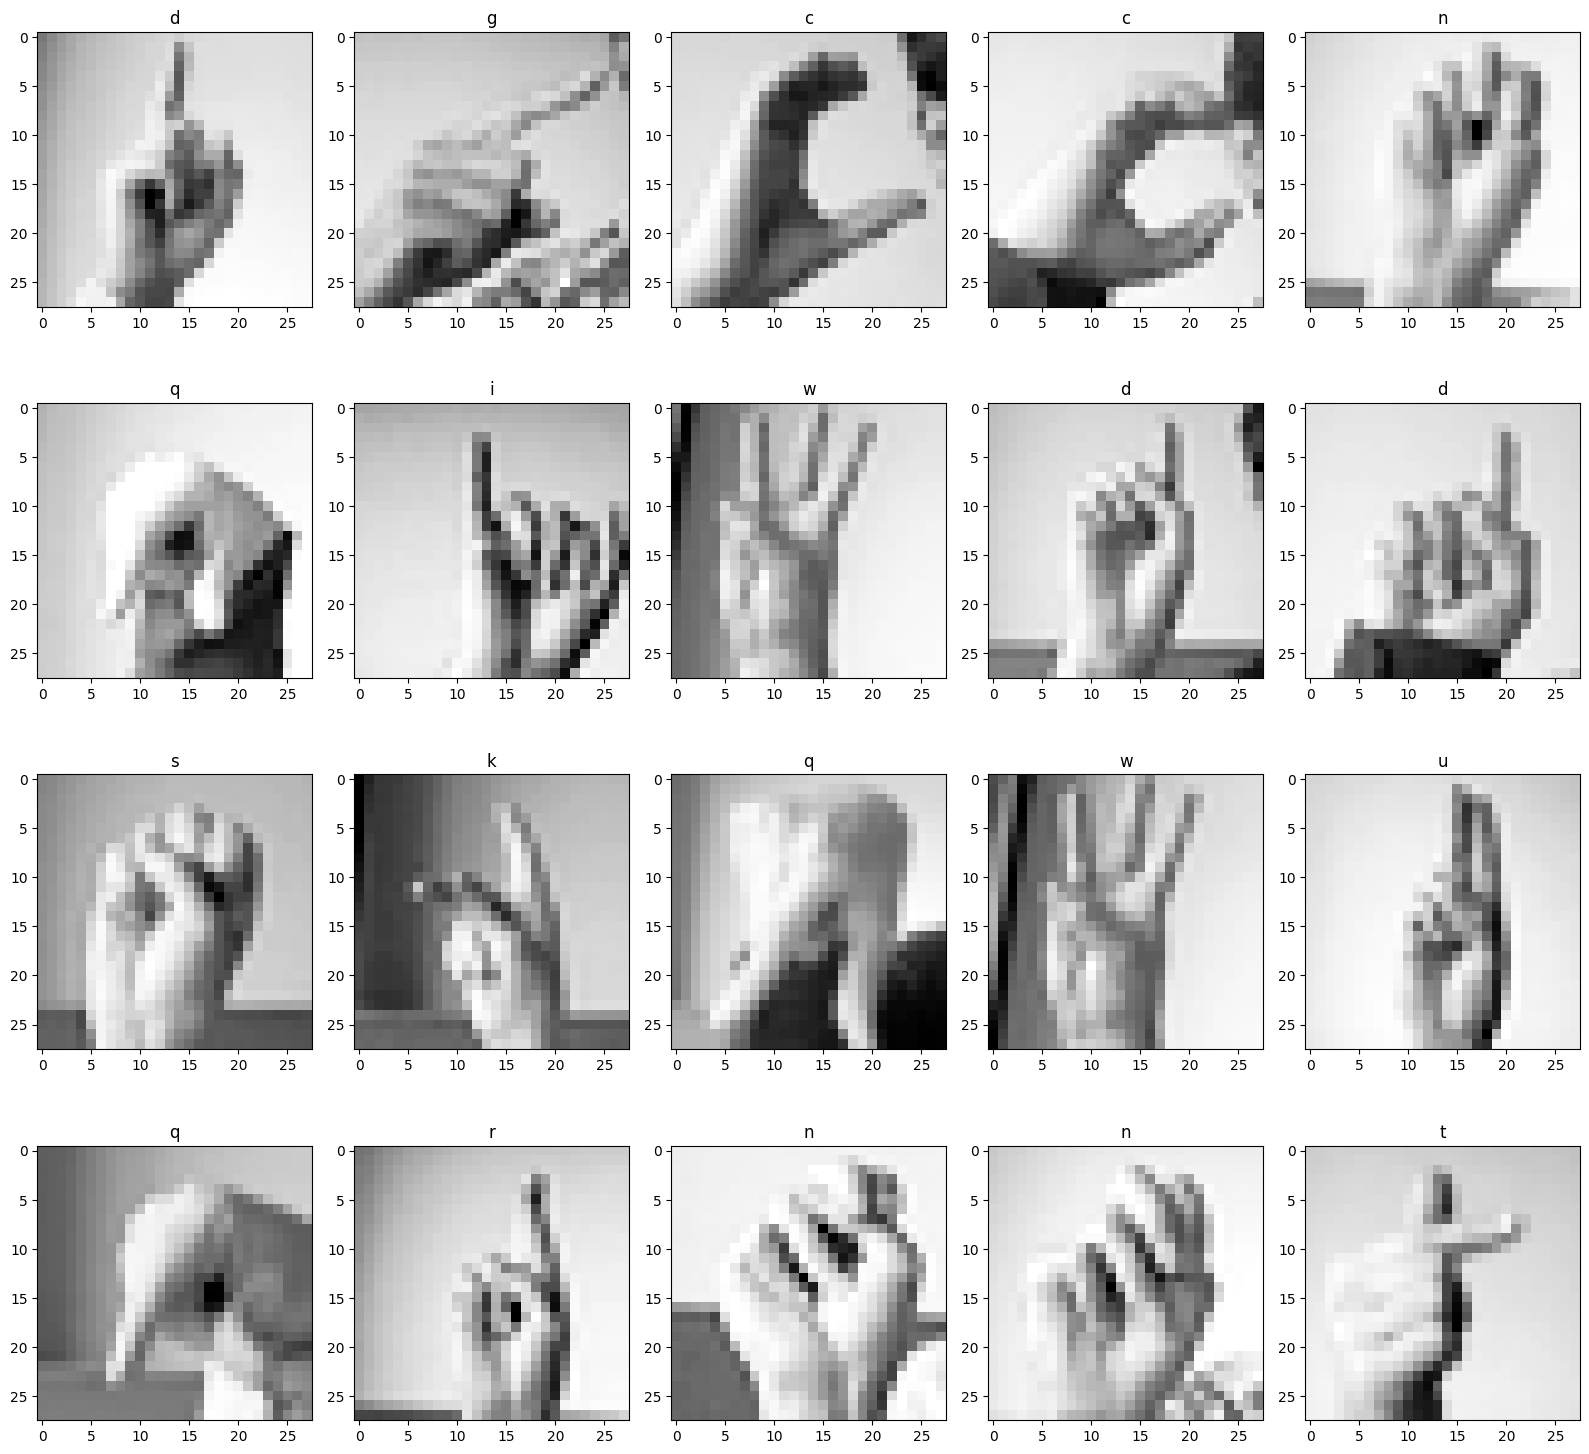

In [14]:
plot_images(train_img, train_labels)

## Preprocessing the data

In [22]:
train_df['label'].unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

In [24]:
# Getting classes

class_names = [chr(ord('a') + i) for i in range(26)]

print(f"Total Classes: {len(class_names)} and Class_Names: {class_names}")

Total Classes: 26 and Class_Names: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [31]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)


train_images = np.expand_dims(train_img, axis = 3)
val_images = np.expand_dims(val_img, axis = 3)


train_data = train_datagen.flow(train_images,
                                train_labels,
                                batch_size=32)

val_data = val_datagen.flow(val_images,
                            val_labels,
                            batch_size=32)

## Building Model

### 1. CNN Model

In [33]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=((28,28,1))),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [44]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dropout (Dropout)           (None, 3200)              0

In [45]:
history = model.fit(train_data,
                    epochs=12,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data)
                    )

Epoch 1/12
858/858 [==============================] - 17s 18ms/step - loss: 0.5745 - accuracy: 0.8074 - val_loss: 0.2596 - val_accuracy: 0.9048
Epoch 2/12
858/858 [==============================] - 13s 15ms/step - loss: 0.5062 - accuracy: 0.8302 - val_loss: 0.1797 - val_accuracy: 0.9381
Epoch 3/12
858/858 [==============================] - 13s 16ms/step - loss: 0.4536 - accuracy: 0.8487 - val_loss: 0.1362 - val_accuracy: 0.9603
Epoch 4/12
858/858 [==============================] - 13s 15ms/step - loss: 0.4046 - accuracy: 0.8636 - val_loss: 0.0901 - val_accuracy: 0.9762
Epoch 5/12
858/858 [==============================] - 14s 16ms/step - loss: 0.3671 - accuracy: 0.8762 - val_loss: 0.0823 - val_accuracy: 0.9815
Epoch 6/12
858/858 [==============================] - 13s 15ms/step - loss: 0.3512 - accuracy: 0.8847 - val_loss: 0.0656 - val_accuracy: 0.9799
Epoch 7/12
858/858 [==============================] - 13s 16ms/step - loss: 0.3255 - accuracy: 0.8922 - val_loss: 0.0470 - val_accuracy:

In [46]:
def loss_curve(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label="Training_Loss")
  plt.plot(epochs, val_loss, label="Val_Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="Training_Accuracy1")
  plt.plot(epochs, val_accuracy, label="Val_Accuracy")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

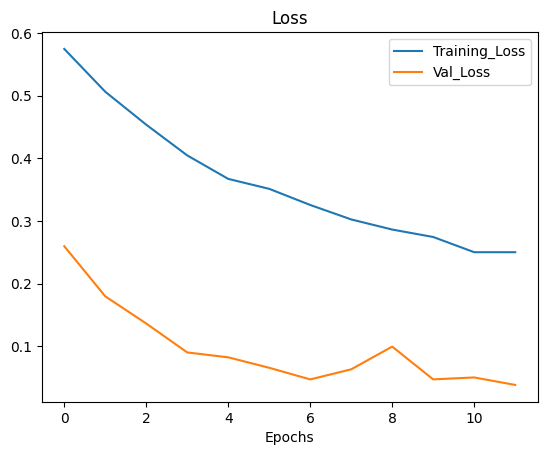

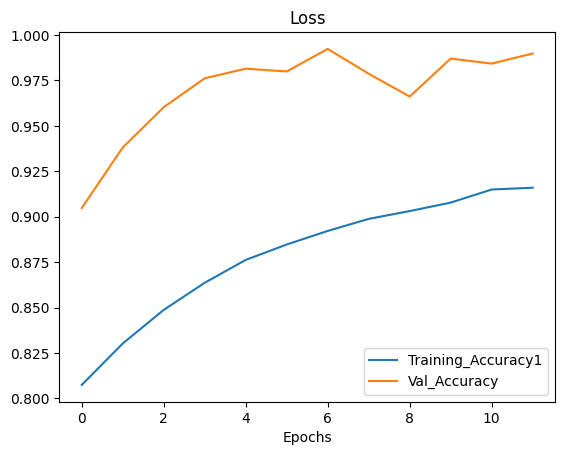

In [47]:
loss_curve(history)

# Saving the model

In [70]:
model.save('signModel.h5')